# Pràctica 2


Presentació:
Hem seleccionat el joc de dades del Titànic donat que compta amb un gran nombre de variables numèriques i categòriques i el tamany total del joc de dades és bastant bo per a realitzar tasques de processament de dades i d'anàlisi exploratori de dades.

## Descripció del joc de dades

* Descripció curta: el joc de dades conté informació sobre el tipus de passatger del Titànic, les característiques del seu viatge i si va sobreviure o no.
* URL de descàrrega: https://data.world/nrippner/titanic-disaster-dataset
* Mida del joc de dades: 1309 files, 14 columnes
* Columnes:
    * survival: binari, 0=NO, 1=Sí. Booleà
    * class: tipus de passatger, 1=de primera, 2=de segona, 3=de tercera. Enter
    * name: nom del passatger. Cadena de text
    * sex: sexe del passatger. Cadena de text
    * age: edat en anys. Decimal
    * sibsp: número d'esposes o germans. Enter
    * parch: número de pares o fills. Enter
    * ticket: número del tíquet. Enter
    * fare: preu del billet. Decimal
    * cabin: cabina. Cadena de text
    * embarked: port d'embarcament (C = Cherbourg, Q = Queenstown, S = Southampton). Cadena de text
    * boat: bot salva-vides en el cas d'haver sobreviscut. Cadena de text
    * body: número del cos en el cas de no haver sobreviscut i que s'hagi trobat el cos. Enter
    * home_dest: destinació del passatger. Cadena de text

**Quina pregunta pretén respondre?**

La pregunta principal que tractarem de respondre en aquest projecte és si existeixen relacions entre les característiques del passatgers i el seu índex de supervivència.

**Objectiu:**
Per tant, com acabem de comentar l'objectiu principal és conèixer si existeixen relacions entre el tipus de passatger i el seu índex de supervivència.


## Integració i selecció de les dades d’interès a analitzar
Importem les llibreries necessàries per a treballar en aquest projecte:

In [1]:
# importació de llibreries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import *
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import kstest
import statsmodels.api as sm
import pylab
import random
from matplotlib import pyplot


Llegim el joc de dades i mostrem els les primeres files:

In [2]:
df = pd.read_csv('titanic.csv')
df.head(3)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
0,1,True,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,False,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
df.shape

(1309, 14)

## Neteja de dades

Fem un cop d'ull als valors perduts del joc de dades:

In [4]:
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home_dest     564
dtype: int64

In [5]:
#Com que només hi ha 1 valor missing de fare el podem intentar substituir per la mitjana
df.describe()[['fare']]

,fare
count,1308.000000
mean,33.295479
std,51.758668
min,0.000000
25%,7.895800
50%,14.454200
75%,31.275000
max,512.329200


In [6]:
df[['pclass']][df['fare'].isna()]
#La pclass del missing es 3

,pclass
1225,3


In [7]:
#El preu esta molt influenciat per la classe, aleshores anem a veure separat per aixó
df[['fare','pclass']].groupby('pclass').mean()

,fare
pclass,
1,87.508992
2,21.179196
3,13.302889


In [8]:
#Aleshores substituim el valor missing de fare per 13.3

**Com tractarem els valors perduts?**
* age: donat que és rellevant per a aquest estudi procedirem a eliminar les files que no contiguin l'edat.
* fare: substituim per 13.3
* cabin: no és rellevant. Omplirem els valors perduts amb "desconegut".
* embarked: és rellevant amb el que també s'eliminaran les files que continguin aquests valors.
* boat, body i home_dest: no és rellevant. Omplirem els valors perduts amb "desconegut".

### Tractament dels valors perduts
#### Eliminació de files
Eliminem les files que continguin valors perduts a age o a embarked. Primer comprovem quin tant per cent d'informació perdíem a l'eliminar-los, si és poc procedirem a eliminar:

In [9]:
# fem el recompte de files
total_files = df.shape[0]

# fem el recompte de valors perduts a les dues columnes
nan_age = df.age.isna().sum()
nan_embarked = df.embarked.isna().sum()
nan_fare = df.fare.isna().sum()

# veiem quin tant per cent d'informació perdrem
print("La columna age té {} valors perduts d'un total de {}, eliminant aquestes files eliminarem el {}% de les dades."
      .format(nan_age, total_files, nan_age / total_files * 100))
print("La columna embarked té {} valors perduts d'un total de {}, eliminant aquestes files eliminarem el {}% de les dades."
      .format(nan_embarked, total_files, nan_embarked / total_files * 100))
print("La columna fare té {} valors perduts d'un total de {}, eliminant aquestes files eliminarem el {}% de les dades."
      .format(nan_fare, total_files, nan_fare / total_files * 100))

La columna age té 263 valors perduts d'un total de 1309, eliminant aquestes files eliminarem el 20.091673032849503% de les dades.
La columna embarked té 2 valors perduts d'un total de 1309, eliminant aquestes files eliminarem el 0.15278838808250572% de les dades.
La columna fare té 1 valors perduts d'un total de 1309, eliminant aquestes files eliminarem el 0.07639419404125286% de les dades.


Tenint en compte aquesta pèrdua d'informació procedim a eliminar els valors perduts.

In [10]:
# eliminem files amb valors perduts
df = df.dropna(subset=['age', 'embarked'])

total_files = df.shape[0]
print("Total de files: ", total_files)

Total de files:  1044


In [11]:
df[['fare']] = df[['fare']].fillna(value=13.3)

#### Substitució dels valors perduts
En el cas de cabin, boat, body i home_dest procedirem a substituir, com hem comentat, els valors perduts per la paraula "desconegut".

In [12]:
df[['cabin', 'boat', 'body', 'home_dest']] = df[['cabin', 'boat', 'body', 'home_dest']].fillna(value='desconegut')

Veiem com ha quedat el sumatori dels valors perduts al joc de dades:

In [13]:
df.isnull().sum()

pclass       0
survived     0
name         0
sex          0
age          0
sibsp        0
parch        0
ticket       0
fare         0
cabin        0
embarked     0
boat         0
body         0
home_dest    0
dtype: int64

#### Valors Extrems


**Tenim 3 possibles tractaments pels valors extrems:**

    -Eliminar les files corresponents a aquets valors
    -Definir limits superiors i/o inferiors i substituir els valors extrems pels valors limits
    -Tractar-los com valors missings (i substituir per la mitjana)

**Fem una primera vizualització dels valors extrems de les variables numeriques**

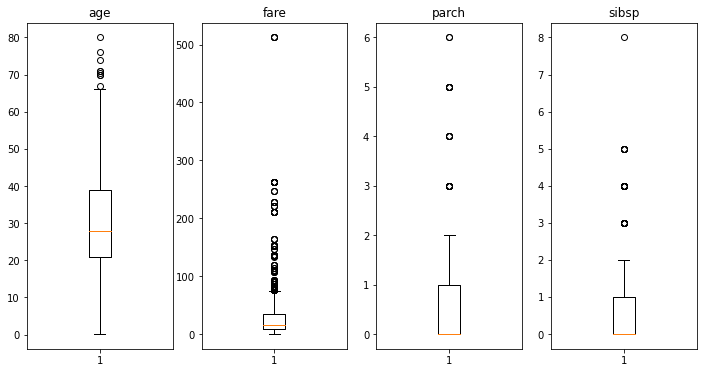

In [14]:
fig = plt.figure(num=None, figsize=(12, 6), facecolor='w')
#Afegim també els boxplot de cada variable
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.title.set_text('age')
ax1.boxplot(df['age'])
ax2.title.set_text('fare')
ax2.boxplot(df['fare'])
ax3.title.set_text('parch')
ax3.boxplot(df['parch'])
ax4.title.set_text('sibsp')
ax4.boxplot(df['sibsp'])
plt.show()

Observem que les variables Age i Fare poden tenir valors extrems

In [15]:
df.describe()[['fare', 'age']]

,fare,age
count,1044.000000,1044.000000
mean,36.580703,29.842593
std,55.731580,14.390746
min,0.000000,0.166700
25%,8.050000,21.000000
50%,15.745850,28.000000
75%,34.865650,39.000000
max,512.329200,80.000000


Estudiem en funció de pclass

In [16]:
df.groupby('pclass').describe()[['fare']]

fare                                                           \
        count       mean        std     min       25%    50%       75%   
pclass                                                                   
1       282.0  92.316091  82.888168  0.0000  34.86565  67.95  110.8833   
2       261.0  21.855044  13.540335  9.6875  13.00000  15.75   26.0000   
3       501.0  12.880139   9.723371  0.0000   7.77500   8.05   15.1000   

                  
             max  
pclass            
1       512.3292  
2        73.5000  
3        69.5500

Analitzarem visualment la variable fare per pclass

C:\Users\David\AppData\Local\Temp/ipykernel_18380/1459580763.py:22: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(2)


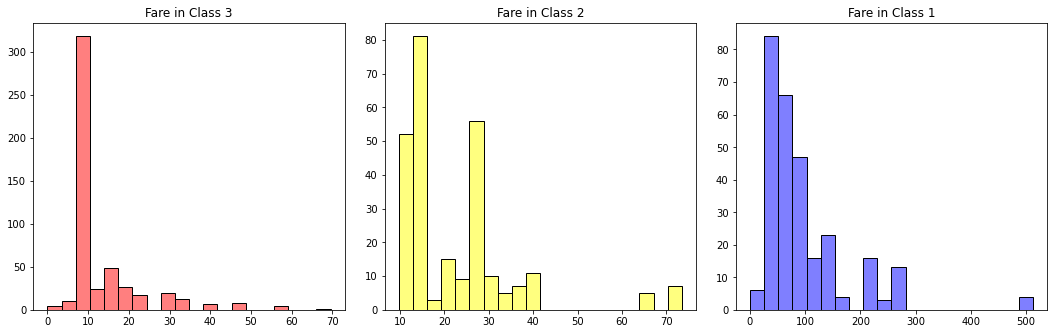

In [17]:
# gràficament també podem observar això

mr1=df['fare'][df['pclass']==1]
mr2=df['fare'][df['pclass']==2]
mr3=df['fare'][df['pclass']==3]

plt.subplots(figsize=(15, 5))


plt.subplot(1, 3, 1)
plt.hist(list(mr3), bins=20, label='Class 3',linewidth=1, edgecolor='black',fc=(1, 0, 0, 0.5))
plt.title('Fare in Class 3')

plt.subplot(1, 3, 2)
plt.hist(list(mr2), bins=20, label='Class 2',linewidth=1, edgecolor='black',fc=(1, 1, 0, 0.5))
plt.title('Fare in Class 2')

plt.subplot(1, 3, 3)
plt.hist(list(mr1), bins=20, label='Class 1',linewidth=1, edgecolor='black',fc=(0, 0, 1, 0.5))
plt.title('Fare in Class 1')

plt.tight_layout(2)
plt.show()

**Amb l'histograma observem els següents outliers:**

    -Cas 1: en la pclass 1 tenim un outlier en el 500
    -Cas 2: em la pclass 2 tenim dos outliers amb fare>60
    -Cas 3: em la pclass 3 tenim tres outliers amb fare>40
    
Per l'altra banda observem que tant la pclass 1 i 3 tenen fare casos amb fare igual a 0. Considerem que aquests valors són erronis i els substituirem per la mitjana.





In [18]:
df.groupby('pclass').describe()[['age']]

age                                                       
        count       mean        std     min   25%   50%    75%   max
pclass                                                              
1       282.0  39.083038  14.535653  0.9167  28.0  39.0  49.75  80.0
2       261.0  29.506705  13.638628  0.6667  22.0  29.0  36.00  70.0
3       501.0  24.816367  11.958202  0.1667  18.0  24.0  32.00  74.0

C:\Users\David\AppData\Local\Temp/ipykernel_18380/1249790875.py:22: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(2)


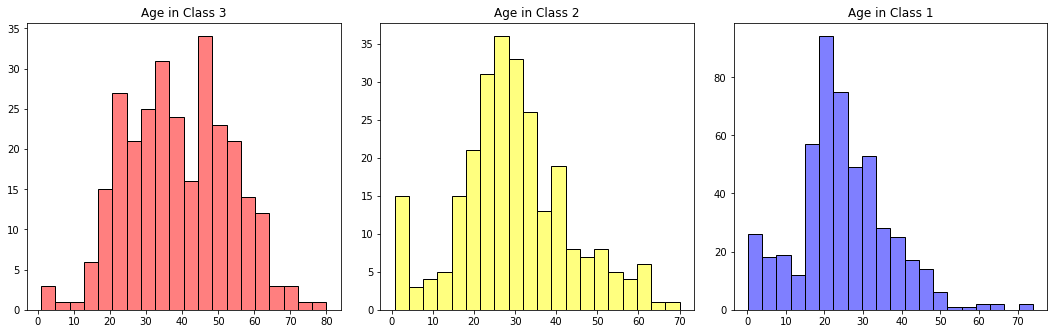

In [19]:
# gràfica

ar1=df['age'][df['pclass']==1]
ar2=df['age'][df['pclass']==2]
ar3=df['age'][df['pclass']==3]

plt.subplots(figsize=(15, 5))


plt.subplot(1, 3, 1)
plt.hist(list(ar1), bins=20, label='Class 3',linewidth=1, edgecolor='black',fc=(1, 0, 0, 0.5))
plt.title('Age in Class 3')

plt.subplot(1, 3, 2)
plt.hist(list(ar2), bins=20, label='Class 2',linewidth=1, edgecolor='black',fc=(1, 1, 0, 0.5))
plt.title('Age in Class 2')

plt.subplot(1, 3, 3)
plt.hist(list(ar3), bins=20, label='Class 1',linewidth=1, edgecolor='black',fc=(0, 0, 1, 0.5))
plt.title('Age in Class 1')

plt.tight_layout(2)
plt.show()

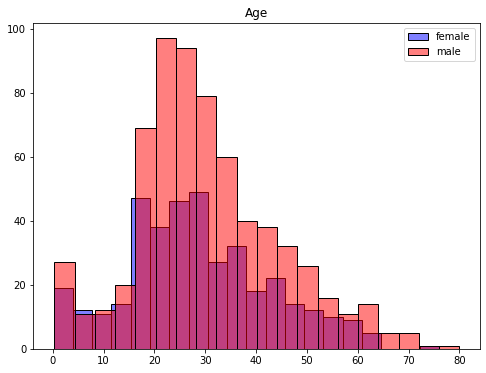

In [20]:
#Separat per sexe tampoc veiem diferencies

%matplotlib inline
saF=df['age'][df['sex']=='female']
saM=df['age'][df['sex']=='male']
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(8,6))
pyplot.hist(list(saF), bins=20, edgecolor='black', linewidth=1, label='female', fc=(0, 0, 1, 0.5))
pyplot.hist(list(saM), bins=20, edgecolor='black', linewidth=1, label='male',fc=(1, 0, 0, 0.5))
pyplot.legend(loc='upper right')
pyplot.title('Age')
pyplot.show()

Considerem que per l'edad no hi han valors extrems

### Tractament dels valors extrems


### Cas 1

In [21]:
df.loc[df.loc[:, 'fare'] >500]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
49,1,True,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,3,desconegut,"Austria-Hungary / Germantown, Philadelphia, PA"
50,1,True,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C,3,desconegut,"Germantown, Philadelphia, PA"
183,1,True,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,3,desconegut,desconegut
302,1,True,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,desconegut,C,3,desconegut,desconegut


In [22]:
df = df[df.fare < 500]

#Eliminem les files amb els valors extrems del cas 1.

In [23]:
df.shape

(1040, 14)

### Cas 2

In [24]:
df=df[((df.fare <60)  & (df.pclass==2)) | (df.pclass!=2)]


In [25]:
df.shape

(1028, 14)

### Cas 3

In [26]:
df=df[((df.fare <50)  & (df.pclass==3)) | (df.pclass!=3)]

In [27]:
df.shape

(1023, 14)

### Tractaments del fare = 0

Primer fem una primera vista dels casos amb fare=0.

In [28]:
df.loc[(df['fare'] == 0),:]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
7,1,False,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0,A36,S,desconegut,desconegut,"Belfast, NI"
150,1,False,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,desconegut,110.0,desconegut
170,1,True,"Ismay, Mr. Joseph Bruce",male,49.0,0,0,112058,0.0,B52 B54 B56,S,C,desconegut,Liverpool
234,1,False,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0,desconegut,S,desconegut,desconegut,"Rotterdam, Netherlands"
896,3,False,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,desconegut,S,desconegut,desconegut,desconegut
898,3,False,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,desconegut,S,desconegut,desconegut,desconegut
963,3,False,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,desconegut,S,desconegut,desconegut,desconegut
1254,3,True,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,desconegut,S,15,desconegut,desconegut


In [29]:
cond1 = (df['fare'] == 0) & (df['pclass'] == 1) 
cond3 = (df['fare'] == 0) & (df['pclass'] == 3) 


In [30]:
df.loc[cond1,'fare'] = 87.50
df.loc[cond3,'fare'] = 13.30

In [31]:
df.groupby('pclass').describe()[['fare']]

fare                                                              
        count       mean        std     min     25%    50%    75%       max
pclass                                                                     
1       278.0  87.531730  65.395002  5.0000  36.250  70.15  108.9  263.0000
2       249.0  19.536814   8.602456  9.6875  13.000  14.50   26.0   41.5792
3       496.0  12.521404   8.495331  3.1708   7.775   8.05   14.5   46.9000

# Anàlisi de dades
## Visualització de dades
Veiem primer les distribucions de les columnes principals per a tenir una idea més acurada del joc de dades.

Passatgers per tipus de classe:


<AxesSubplot:ylabel='pclass'>

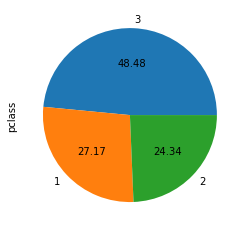

In [32]:
# columna classe
print('Passatgers per tipus de classe:')
df['pclass'].value_counts().plot(kind='pie',autopct='%.2f')

Quina és la distribució per edats i sexe?


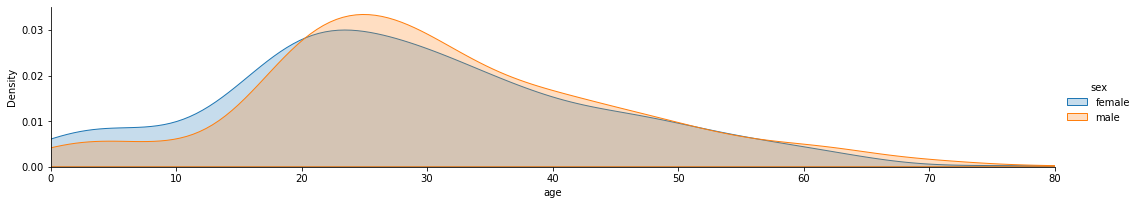

In [33]:
# columna age i sex
print("Quina és la distribució per edats i sexe?")

as_fig = sns.FacetGrid(df,hue='sex',aspect=5)

as_fig.map(sns.kdeplot,'age',shade=True)

oldest = df['age'].max()

as_fig.set(xlim=(0,oldest))

as_fig.add_legend()

Recompte de persones en funció del sexe i de la classe: 


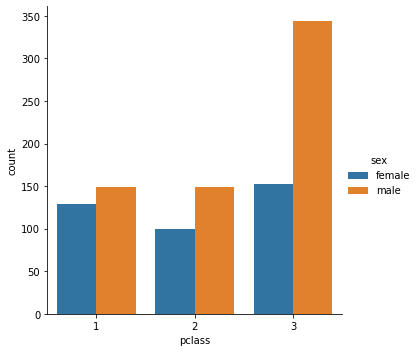

In [34]:
print("Recompte de persones en funció del sexe i de la classe: ")
sns.catplot(x='pclass',
            data=df, 
            hue='sex', 
            kind='count')

Des d'on van embarcar i quin tipus de classe de passatgers s'hi van pujar?


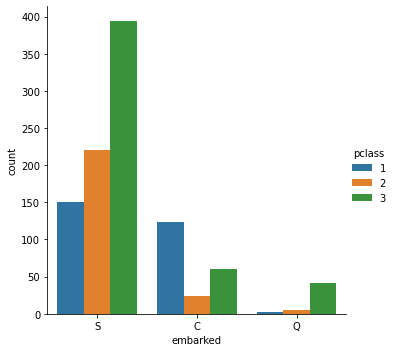

In [35]:
print("Des d'on van embarcar i quin tipus de classe de passatgers s'hi van pujar?")
sns.catplot(x='embarked',data=df,
               hue='pclass',
               kind='count')

## Anàlisi exploratori dels supervivents

In [68]:
# creem una funció que ens compari dues columnes i ens mostri un gràfic de barres

def graficar_dues_columnes(df, 
                            col1, 
                            col2, 
                            legloc='upper right',
                            plt_style = 'gggraficar',
                            color_palette="dark", 
                            sorter=None, 
                            stacked=False,
                            kind = 'bar', 
                            percentage = True,
                            custom_title=None, 
                            minimal=True, 
                            figsize=(14,6), width=0.6):   
    
    # creació de la funció del gràfic
    def graficar(table, 
            legloc='upper right',
            plt_style = 'seaborn-ticks',
            color_palette="dark",
            sorter=None, 
            stacked=False,
            kind = 'bar', 
            percentage = True,
            custom_title=None, 
            minimal=True, 
            figsize=(19,10), 
            width=0.7 ):     
        agrupat = table

        if percentage == True:
            agrupat = np.round(agrupat.divide(agrupat['Total'],axis=0)*100,0)
        try:   
            del agrupat['Total']
        except:
            pass

        if sorter:
            agrupat = agrupat[sorter]

        plt.style.use(plt_style)
        sns.set_palette(sns.color_palette(color_palette))
        ax = agrupat.plot(kind=kind,stacked=stacked, figsize=figsize, width=width)
        _ = plt.setp(ax.get_xticklabels(), rotation=0)
        plt.legend(loc=legloc)

        if percentage == True:
          for p in ax.patches:
                ax.annotate('{}%'.format(int(np.round(p.get_height(),decimals=2))),
                                             (p.get_x()+p.get_width()/2.,
                                              p.get_height()), ha='center', va='center',
                                            xytext=(0, 10), textcoords='offset points')
        else:
          for p in ax.patches:
                ax.annotate(np.round(p.get_height(),decimals=2),
                                             (p.get_x()+p.get_width()/2.,
                                              p.get_height()), ha='center', va='center',
                                            xytext=(0, 10), textcoords='offset points')
        if minimal == True:
            ax.get_yaxis().set_ticks([])
            plt.xlabel('')
            sns.despine(top=True, right=True, left=True, bottom=False);
        else:
            pass     
        plt.title(custom_title)
    
    
    
    # creació del gràfic
    agrupat = df.groupby([col2,col1]).size().unstack(col2)
    
    agrupat['Total'] = agrupat.sum(axis=1)
   
    graficar(agrupat, 
            legloc=legloc,
            plt_style = plt_style,
            color_palette=color_palette,
            sorter=sorter, 
            stacked=stacked,
            kind = kind, 
            percentage = percentage,
            custom_title=custom_title, 
            minimal=minimal, 
            figsize=figsize, 
            width=width)  

Quin tant per cent va sobreviure?


<AxesSubplot:ylabel='survived'>

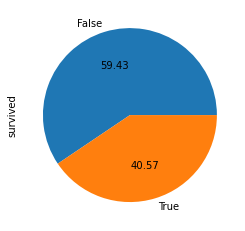

In [36]:
# columna survived
print('Quin tant per cent va sobreviure?')
df['survived'].value_counts().plot(kind='pie', autopct='%.2f')

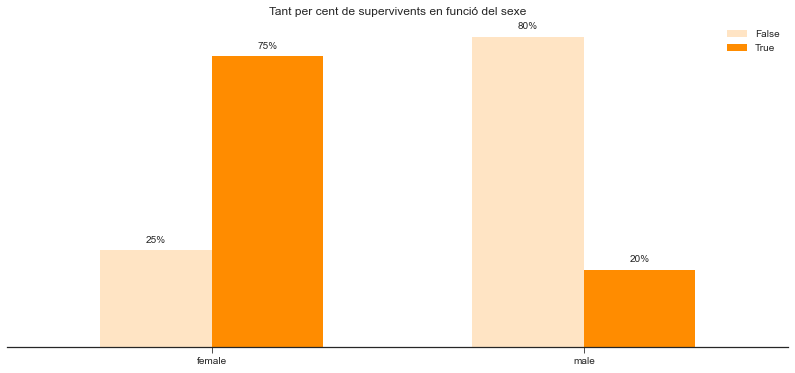

In [86]:
# sex i survived
graficar_dues_columnes(df,
                       'sex', 
                       'survived', 
                       color_palette=('bisque','darkorange'),
                       plt_style = 'seaborn-ticks', 
                       custom_title='Tant per cent de supervivents en funció del sexe')

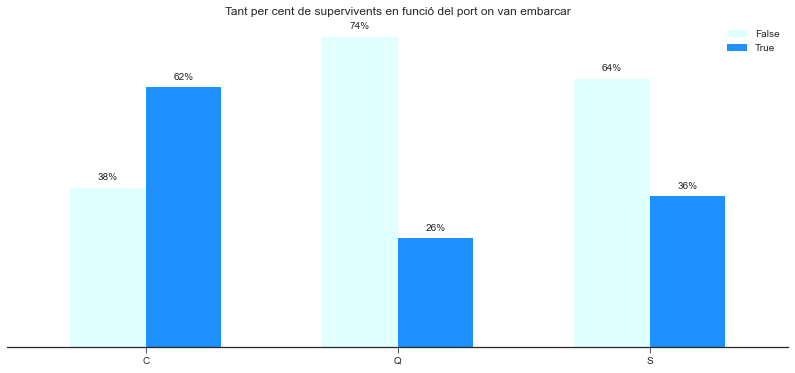

In [74]:
# embarked i survived
graficar_dues_columnes(df,
                       'embarked', 
                       'survived', 
                       color_palette=('lightcyan','dodgerblue'),
                       plt_style = 'seaborn-ticks', 
                       custom_title='Tant per cent de supervivents en funció del port on van embarcar')

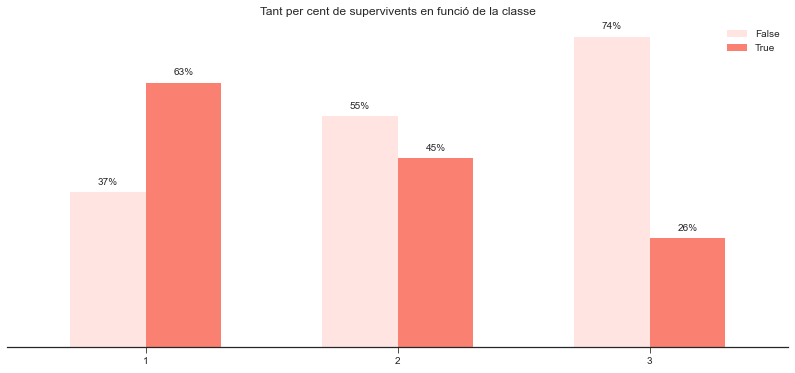

In [88]:
# pclass i survived
graficar_dues_columnes(df,
                       'pclass', 
                       'survived', 
                       color_palette=('mistyrose','salmon'),
                       plt_style = 'seaborn-ticks', 
                       custom_title='Tant per cent de supervivents en funció de la classe')

Supervivents per edat


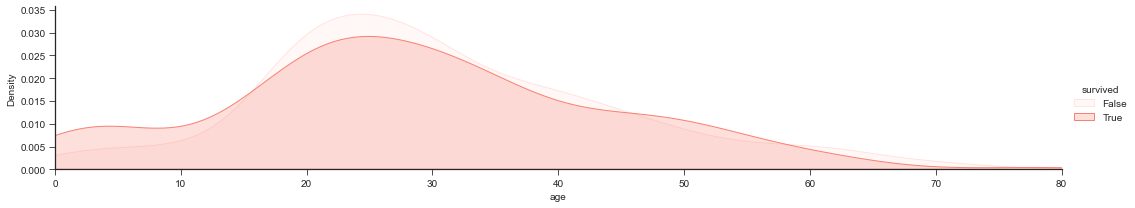

In [91]:
# columna age i sex
print("Supervivents per edat")

as_fig = sns.FacetGrid(df,hue='survived',aspect=5)

as_fig.map(sns.kdeplot,'age',shade=True)

oldest = df['age'].max()

as_fig.set(xlim=(0,oldest))

as_fig.add_legend()

## Anàlisi de correlacions
### Normalització del joc de dades

#### - Variable Age

#### Test de Kolmogorov-Smirnov per la normalitat

In [39]:
from scipy.stats import kstest

#perform Kolmogorov-Smirnov test
kstest(df['age'], 'norm')

KstestResult(statistic=0.9654145203456915, pvalue=0.0)

#### Test de e Shapiro-Wilk per la normalitat

In [55]:

shapiro_test = stats.shapiro(df['age'])
shapiro_test

ShapiroResult(statistic=0.9798189997673035, pvalue=1.0307183578861512e-10)

#### Veiem que pvalue es inferior a 0.05 tan en el test de KS con en el test de S-W. Aleshores rebutjem la hipòtesi nul·la i es conclou que l'edad no té distribució normal.

#### - Variable fare

In [41]:

#perform Kolmogorov-Smirnov test
kstest(df['fare'], 'norm')

KstestResult(statistic=0.9992399011538781, pvalue=0.0)

In [42]:
from scipy import stats
stats.shapiro(df['fare'])

ShapiroResult(statistic=0.5949857234954834, pvalue=1.4433374182545616e-43)

#### Veiem que pvalue es inferior a 0.05 tan en el test de KS con en el test de S-W. Aleshores rebutjem la hipòtesi nul·la i es conclou que el preu no té distribució normal.

In [45]:
# normalitzadió per desviació típica
norm_df=(df-df.mean(numeric_only=True))/df.std(numeric_only=True)

 ### Homogeneïtat de la variància

#### Comprobarem la homogeneïtat de la variància de les variables age i fare pels diferents grups de les variables pclass, sex i survived:

In [46]:
#Estudiarem les variables age i fare en els grups: pclass, sex i surived
#Com que no son variables normals hem d'aplicar el test no parametric de Fligner-Killeen:

age_class1=df['age'][df['pclass']==1]
age_class2=df['age'][df['pclass']==2]
age_class3=df['age'][df['pclass']==3]
age_sexF=df['age'][df['sex']=='female']
age_sexM=df['age'][df['sex']=='male']
age_survived0=df['age'][df['survived']==0]
age_survived1=df['age'][df['survived']==1]
fligner_age_class = stats.fligner(age_class1, age_class2,age_class3, center='median')
fligner_age_sex = stats.fligner( age_sexF,age_sexM, center='median')
fligner_age_survived = stats.fligner(age_survived0, age_survived1, center='median')

In [47]:
print ("El valor de p-value del test de age en la variable pclass es:", fligner_age_class.pvalue) 

El valor de p-value del test de age en la variable pclass es: 2.1492895307682507e-06


In [48]:
print ("El valor de p-value del test de age en la variable sex es:", fligner_age_sex.pvalue) 

El valor de p-value del test de age en la variable sex es: 0.5906768089205406


In [49]:
print ("El valor de p-value del test de age en la variable survived es:", fligner_age_survived.pvalue) 

El valor de p-value del test de age en la variable survived es: 0.1093881286433002


### Observem que menys en el grup pclass la variable age no rebujta la hipotesis nul-la i per tant te variàncies estadísticament similars. 

In [50]:
#Estudiarem les variables fare i fare en els grups: pclass, sex i surived
#Com que no son variables normals hem d'aplicar el test no parametric de Fligner-Killeen:
from scipy import stats
fare_class1=df['fare'][df['pclass']==1]
fare_class2=df['fare'][df['pclass']==2]
fare_class3=df['fare'][df['pclass']==3]
fare_sexF=df['fare'][df['sex']=='female']
fare_sexM=df['age'][df['sex']=='male']
fare_survived0=df['fare'][df['survived']==0]
fare_survived1=df['fare'][df['survived']==1]
fligner_fare_class = stats.fligner(fare_class1, fare_class2,fare_class3, center='median')
fligner_fare_sex = stats.fligner( fare_sexF,fare_sexM, center='median')
fligner_fare_survived = stats.fligner(fare_survived0, fare_survived1, center='median')

In [51]:
print ("El valor de p-value del test de fare en la variable pclass es:", fligner_fare_class.pvalue) 

El valor de p-value del test de fare en la variable pclass es: 1.1562174548043137e-110


In [52]:
print ("El valor de p-value del test de fare en la variable sex es:", fligner_fare_sex.pvalue) 

El valor de p-value del test de fare en la variable sex es: 2.117707590275233e-24


In [53]:
print ("El valor de p-value del test de fare en la variable survived es:", fligner_fare_survived.pvalue) 

El valor de p-value del test de fare en la variable survived es: 2.3345626395466748e-23


##### D'altre banda, per la variable fare en els grups estudiats el p-value es inferior a 0.05 i per tant es rebutja la hipòtesi nul·la d’homoscedasticitat i es conclou que la variable fare presenta variàncies estadísticament diferents per als diferents grups de pclass, sex i survived.

### Correlació entre variables

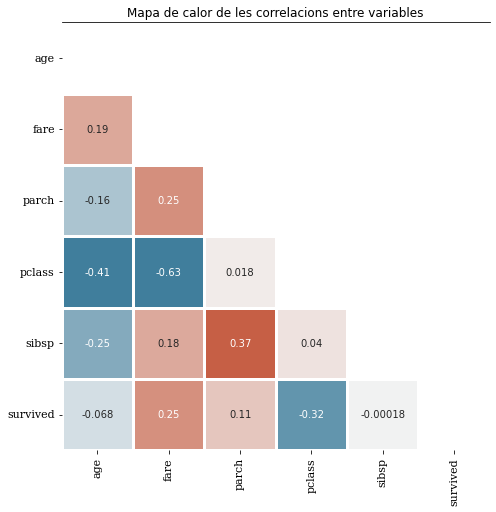

In [54]:
# apliquem la fòrmula de correlació al joc de dades normalitzat
corr = norm_df.corr()

# creem el mapa de calor
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, 
            square=True, 
            mask=mask,
            linewidth=2.5, 
            vmax=0.4, vmin=-0.4, 
            cmap=cmap, 
            cbar=False, 
            ax=ax,
            annot=True)

ax.set_yticklabels(ax.get_xticklabels(), fontfamily='serif', rotation = 0, fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=11)

ax.spines['top'].set_visible(True)

plt.tight_layout()
plt.title("Mapa de calor de les correlacions entre variables")
plt.show()

La correlació més alta la trobem entre classe i preu del billet, mentres que la més baixa la trobem entre el número de persones o germans i la variable survived.

# Conclusions finals de l'estudi

L'objectiu principal d'aquest estudi tal i com hem comentat a l'inici era conèixer si existeixen relacions entre les diferents característiques de cada passatger i el tant per cent de supervivència de cada grup.
En base a l'anàlisi visual en el que hem vist el tant per cent de supervivents de les principals variables categòriques podem extraure que:
* El percentatge de mortaldat dels homes va ser molt superior al de les dones, tenin aquests un 80% i les dones tan sols un 25%.
* L'únic port d'entrada que va tenir més supervivents que morts va ser C. Aquesta relació tampoc implica causalitat.
* Hem pogut veure com, en funció de la classe en la que viatjaven, quan més alta era més tant per cent de supervivents hi havien. 

En base a l'anàlisi de les variables numèriques hem vist que:
* La única correlació forta existeix entre la classe i la supervivència. És quelcom que hem pogut veure a l'anàlisi visual i amb l'anàlisi de correlació s'ha reforçat.
* La segona correlació més alta és entre el preu del tíquet i la supervivència.
* Les altres variables numèriques tenen correlacions dèbils o gairebé inexistents amb la supervivència.